In [95]:
import networkx as nx
import numpy as np
import cvxpy as cp
from itertools import chain, combinations
import matplotlib.pyplot as plt
import random

In [96]:
def make_graph(n,initial_capacity=1000,seed=110):
    
    #n=20
    m = 2
    #initial_resource = 1000000
    #initial_capacity = 1000
    initial_graph = nx.barabasi_albert_graph(n, m,seed)
    bidirectional_graph = nx.DiGraph()

    # Copy nodes from the initial graph
    bidirectional_graph.add_nodes_from(initial_graph.nodes())

    for u, v in initial_graph.edges():
        bidirectional_graph.add_edge(u, v, weight=initial_capacity)
        bidirectional_graph.add_edge(v, u, weight=initial_capacity)
    for u, v in initial_graph.edges():
        bidirectional_graph[u][v]['fee'] = 0
        bidirectional_graph[v][u]['fee'] = 0
    
    for node in bidirectional_graph.nodes():
        bidirectional_graph.nodes[node]['balance'] = 0

    #degree_sequence = sorted((d for n, d in bidirectional_graph.degree()), reverse=True)
    #dmax = max(degree_sequence)    
    #for node in bidirectional_graph.nodes():
    #    bidirectional_graph.nodes[node]['budget'] = dmax-bidirectional_graph.degree(node)+1
    return bidirectional_graph

In [97]:
def graph_matrix(graph):
    xx=nx.adjacency_matrix(graph)
    w=np.matrix(xx.todense())
    return w

In [98]:
def balance(n,w):
    ro = np.matrix(np.zeros((n,n)))
    for i in range(n):
        for j in range(n):
            if w[i,j]+w[j,i]!=0:
                x=float(w[j,i]/(w[i,j]+w[j,i]))
                #print(1)
                ro[i,j]=float(0.005*(x))
    return ro

In [99]:
def s_r_array(s,r,n):
    sr=np.zeros(n)
    sr[s]=1
    sr[r]=-1
    sr=np.matrix(sr)
    return sr


In [100]:
# n=20
# bidirectional_graph=make_graph(n)
# w= graph_matrix(bidirectional_graph)
# tx=1
# s=2
# r=1
# sr=s_r_array(s,r,n)
# ro=balance(n,w)*tx
# I = np.matrix(np.ones(n))
# # Define the three-membered set
# set_tot =[i for i in range(n)]
# set_tot=set(set_tot)
# set_ = set_tot
# set_.remove(s)
# # Generate all subsets as lists
# all_subsets = chain.from_iterable(map(list, combinations(set_, j)) for j in range(len(set_) + 1))

# # Define the binary matrix variable
# X = cp.Variable((n, n), boolean=True)
# # Your convex problem formulation using X
# # ...
# # For example, let's say you want to minimize the sum of all elements in the matrix
# objective = cp.Minimize(cp.sum(cp.multiply(X, ro)))
# constraints=[X@I.T-(I @ X).T == sr.T ]
# constraints+=[X@I.T<=1*I,(I @ X).T<=1*I ]

# # Iterate over all subsets
# for i in range(n):
#     for j in range(n):
#         if w[i,j]==0:
#             constraints+= [X[i, j] == 0 ]
#         else:
#             constraints+=[X[i,j]+X[j,i]<=1 ]
    
# w_tot=0
# ro_tot=0
# for subset in all_subsets:
#     if len(subset)<=3:
#         subset.append(s)
#         for i in subset:
#             sett = set_tot
#             sett.difference_update(subset)
#             for j in sett: 
#                 w_tot+= w[i,j]*X[i,j]
#         sett = set_tot
#         sett.difference_update(subset)
#         for i in sett:
#             sett = set_tot
#             sett.difference_update(subset)
#             for j in sett: 
#                 ro_tot+= ro[i,j]*X[i,j] 
#         constraints+=[w_tot >= tx + ro_tot]      
#         #I_s=np.identity(4)
#         #Is=np.matrix(np.zeros((4,4)))
#         #for i in subset:
#         #   I_s[i,i]=0
#         #   Is[i,i]=1
#         #constraints +=[cp.sum(Is @ (cp.multiply(X, w))@ I_s)>= tx + cp.sum(I_s @ (cp.multiply(X, ro))@ I_s)]
# problem = cp.Problem(objective, constraints)

# # Solve the problem


# # Access the optimal value of the matrix
# optimal_matrix = X.value

# print("Optimal Matrix:")
# print(optimal_matrix)

In [101]:
def matrix_to_path(optimal_matrix,s,graph,amount):
    tree=[]
    k2=0
    try:
        for i in range(optimal_matrix.shape[0]):
            for j in range(optimal_matrix.shape[0]):
                if optimal_matrix[i,j]>0.5:
                    tree.append((i,j))
        #print (tree,"godddddddd") 
        data = tree
        first = s
        f=True
        tag=True
        for i in range(len(tree)):
            if s==tree[i][0]:
                tag=False
        if tag :
            return tree ,0
        while(f ):
            f= False
            for i in range(len(data)-1): 
                if data[0][0]!= first :
                    #print(data)
        
                    p=data[i]
                    q=data[i+1]
                    data[i]=q
                    data[i+1]=p
                    f= True
        k=data[0][1] 
        for i in range(1,len(data)-1):
            #print(data)
            if k != data[i][0]:
                for j in range(i,len(data)):
                    #print(data[j])
                    if data[j][0]==k:
                        k2=j   
                        #print(k2)      
                        p=data[i]
                        q=data[k2]
                        data[i]=q
                        data[k2]=p
            k=data[i][1] 

        x=0
        w= graph_matrix(graph)
        ro=balance(len(graph.nodes()),w)
        for (i, j)in data:
            x+=ro[i,j]
        return data,x
    except:
        return [],0



In [102]:
def ro_tot_n(path,TX,graph):
    X=[]
    w= graph_matrix(graph)
    ro=balance(len(graph.nodes()),w)
    for i in range(w.shape[0]):
        for j in range(w.shape[0]):
            if i>=j :
                x=0
                for k in range(len(path)):
                    if (i,j) in path[k]:
                        x+=TX[k]*ro[i,j]
                for kk in range(len(path)):
                    if (j,i) in path[kk]:
                        x-=TX[k]*ro[i,j]
                        #x=np.abs(x)
                if x>=0:
                    if w[i,j]<x:
                        print("in endge",i,",",j,"w is ",w[i,j],"and total payment is ",x)
                else:
                    if w[j,i]<np.abs(x):
                        print("in endge",j,",",i,"w is ",w[j,i],"and total payment is ",np.abs(x))
                x=np.abs(x)
                X.append(x)
    sum=0
    for i in range(len(X)):
        sum+=X[i]     
    return sum

In [103]:
def ro_tot(path1,path2,tx1,tx2,graph):
    x=0
    w= graph_matrix(graph)
    ro=balance(len(graph.nodes()),w)
    for (i,j) in path1:
        if (j,i) in path2:
            x+= np.abs(tx1*ro[i,j]-tx2*ro[j,i])
            path2.remove((j,i))
            print(j,i,"\n")
        else:
            x+= ro[i,j]*tx1
    for (i,j) in path2:
        x+=ro[i,j]*tx2
    return x

In [104]:
def simulate_payment_and_change(graph, sender, recipient, amount):
    adapt_balance(graph)
    tree = find_cheapest_spanning_tree(graph, recipient, amount)
    total_fee = 0
    intermediate_channels = []
    sender_find =False
    for a in tree:
        if sender in a:
            sender_find=True
    if sender_find==False:
        return False  
    else:
        intermediate_nodes= nx.shortest_path(nx.Graph(tree),sender,recipient)

    mm =graph[intermediate_nodes[0]][intermediate_nodes[1]]['fee']
    graph[intermediate_nodes[0]][intermediate_nodes[1]]['fee']= 0
    for v in range(len(intermediate_nodes)-1):
        total_fee += graph[intermediate_nodes[v]][intermediate_nodes[v+1]]['fee']*amount
        intermediate_channels.append((intermediate_nodes[v], intermediate_nodes[v+1]))
    
    total_amount = amount + total_fee
    y=total_amount
    # Check if all intermediate channels have enough capacity for the transaction
    if all(graph[u][v]['weight'] >= total_amount for u, v in intermediate_channels):
        # Increase capacity for edges inside the ring and decrease for opposite edges
        for u, v in intermediate_channels:
            graph[u][v]['weight'] -= total_amount
            graph[v][u]['weight'] += total_amount
            fee_chan=graph[u][v]['fee']
            graph.nodes[u]['balance']+= fee_chan/2
            graph.nodes[v]['balance']+= fee_chan/2
            total_amount=total_amount- (fee_chan*amount)
        graph[intermediate_nodes[0]][intermediate_nodes[1]]['fee']= mm
        # Update sender and recipient balances
        #graph.nodes[recipient]['balance'] += amount
        #graph.nodes[sender]['balance'] -= total_amount

        return True 
    else:
        graph[intermediate_nodes[0]][intermediate_nodes[1]]['fee']= mm
        return False 

In [105]:
def optimization_path(g,s1,r1,s2,r2,tx1,tx2):    
    n=len(g.nodes)
    bidirectional_graph=g
    w= graph_matrix(bidirectional_graph)
    sr1=s_r_array(s1,r1,n)
    sr2=s_r_array(s2,r2,n)
    ro=balance(n,w)
    ro2=balance(n,w)*tx2
    I = np.matrix(np.ones(n))
    # Define the three-membered set
    set_tot =[i for i in range(n)]
    set_tot=set(set_tot)
    set_ = set_tot
    set_.remove(s1)
    # Generate all subsets as lists
    all_subsets = chain.from_iterable(map(list, combinations(set_, j)) for j in range(len(set_) + 1))

    # Define the binary matrix variable
    X1 = cp.Variable((n, n), boolean=True)
    X2 = cp.Variable((n, n), boolean=True)
    # Your convex problem formulation using X
    # ...
    # For example, let's say you want to minimize the sum of all elements in the matrix
    terms = [cp.abs(tx1*(ro[i,j]*X1[i,j]-ro[j,i]*X1[j,i])+tx2*(ro[i,j]*X2[i,j]-ro[j,i]*X2[j,i])) for i in range(n) for j in range(n) if i<j]

    # Use cp.sum on the list of terms
    objective = cp.Minimize(cp.sum(terms))
    
    constraints=[X1@I.T-(I @ X1).T == sr1.T ]
    constraints+=[X2@I.T-(I @ X2).T == sr2.T ]
    #!
    constraints+=[X1@I.T<=1*I,(I @ X1).T<=1*I ]
    constraints+=[X2@I.T<=1*I,(I @ X2).T<=1*I ]
    #!
    # Iterate over all subsets
    for i in range(n):
        for j in range(n):
            constraints+=[w[i,j]-tx1*X1[i,j]>=0]
            constraints+=[w[i,j]-tx2*X2[i,j]-tx1*(X1[i,j]-X1[j,i])>=0]
            #!
            if w[i,j]==0:
                constraints+= [X1[i, j] == 0 ]
                constraints+= [X2[i, j] == 0 ]
            else:
                constraints+=[X1[i,j]+X1[j,i]<=1 ]
                constraints+=[X2[i,j]+X2[j,i]<=1 ]
            #!
#
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # Access the optimal value of the matrix
    optimal_matrix = X1.value
    return optimal_matrix , X2.value , objective.value

In [106]:
I = np.matrix(np.ones(20))
I

matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]])

In [107]:
def optimization_path_n(g,S,R,TX,number):    
    n=len(g.nodes)
    bidirectional_graph=g
    w= graph_matrix(bidirectional_graph)
    SR=[]
    for i in range(number):
        SR.append(s_r_array(S[i],R[i],n))
    ro=balance(n,w)
    
    I = np.matrix(np.ones(n))
    # Define the three-membered set

    # Define the binary matrix variable
    X=[]
    for i in range(number):
        X.append(cp.Variable((n, n), boolean=True))

    # For example, let's say you want to minimize the sum of all elements in the matrix
    terms=[]
    for i in range(n):
        for j in range(n):
            if i>j:
                x=0
                for k in range(number):
                    x+=TX[k]*(ro[i,j]*X[k][i,j]-ro[j,i]*X[k][j,i])
                y= cp.abs(x)
                terms.append(y)
    
    Y=[]
    C=[]            
    for k in range(number):
        v=0
        c=0
        for i in range(n):
            for j in range(n):
                v+=TX[k]*(ro[i,j]*X[k][i,j])
            aa=0
            for a in range(n):
                aa+=X[k][i,a]+X[k][a,i]
            c+=cp.maximum(aa-1,0) 
        C.append(c)
        Y.append(v)
    W=[]
    for i in range(n):
        for j in range(n):
            ww=0
            for k in range(number):
                ww+=TX[k]*(X[k][i,j]-X[k][j,i])
            W.append(cp.maximum(ww-w[i,j],0))
                           
                
    #        x+=TX[k]*(ro[i,j]*X[k][i,j])
    # terms = [cp.abs(tx1*(ro[i,j]*X1[i,j]-ro[j,i]*X1[j,i])+tx2*(ro[i,j]*X2[i,j]-ro[j,i]*X2[j,i])) for i in range(n) for j in range(n) if i<j]
    ssrr=0
    for i in range(number):
        ssrr+= cp.sum(cp.abs(X[i]@I.T- (X[i].T)@I.T -SR[i].T))
    # Use cp.sum on the list of terms
    objective = cp.Minimize(1*cp.sum(terms)+50*cp.sum(C)+1000*cp.sum(W)+1000*ssrr)
    for i in range(number):
        constraints=[X[i]@I.T- (X[i].T)@I.T == SR[i].T ]
        constraints+=[X[i]@I.T<=1*I,(I @ X[i]).T<=1*I ]
        
    for k in range(number):
        for i in range(n):
            for j in range(n):
                Z=0
                if k==number:   
                    for z in range(k):
                        Z+=TX[z]*(X[z][i,j]-X[z][j,i])
                    constraints+=[w[i,j]-Z>=0]
                if w[i,j]==0:
                    constraints+= [X[k][i, j] == 0 ]

                else:
                    constraints+=[X[k][i,j]+X[k][j,i]<=1 ]
    # degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    # dmax = max(degree_sequence)   
    # for i in range(n):
    #     cen=0
    #     for k in range(number):
    #         for j in range(n):
    #             cen+=X[k][i,j]
    #     constraints+=[cen<=(number*(dmax-g.degree(i))/(dmax-2))]
                                           

    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve(solver=cp.SCIPY)#solver=cp.SCIPY)
    print("Solver status:", problem.status)
    print("Solver value:", problem.value)
    VALUE=[]
    for i in range(number):
        VALUE.append(X[i].value)
    #constraint_values = [constraint.value for constraint in constraints]
    #for i in range(len(constraint_values)):
    #    print("Constraint values at optimal solution:", constraint_values[i])

    # Access the optimal value of the matrix
    return VALUE , objective.value

In [108]:
def simulate_payment(graph, sender, recipient, amount):
    x=0
    tree = find_cheapest_spanning_tree(graph, recipient, amount)
    total_fee = 0
    intermediate_channels = []
    sender_find =False
    for a in tree:
        if sender in a:
            sender_find=True
    if sender_find==False:
        return  [] , 0
    else:
        intermediate_nodes= nx.shortest_path(nx.Graph(tree),sender,recipient)
    for v in range(len(intermediate_nodes)-1):
        intermediate_channels.append((intermediate_nodes[v], intermediate_nodes[v+1]))
    w= graph_matrix(graph)
    ro=balance(len(graph.nodes()),w)
    for (i, j)in intermediate_channels:
        x+=ro[i,j]
    return intermediate_channels ,x
    

In [109]:
def find_cheapest_spanning_tree(graph, recipient, transaction):
    Q = set(graph.nodes())
    cost = {v: float('inf') for v in graph.nodes()}
    cost[recipient] = 0
    path = {v: None for v in graph.nodes()}
    while Q:
        vi = min(Q, key=lambda v: cost[v])
        Q.remove(vi)

        for vj in graph.neighbors(vi):
            edge = graph[vj][vi]
            if cost[vi] + edge['fee']*transaction+transaction <= graph[vj][vi]["weight"]:
              if cost[vi]+edge['fee']*transaction < cost[vj] :
                cost[vj] = cost[vi] + edge['fee']*transaction
                path[vj] = (vj, vi)

    T = []
    for v in graph.nodes():
        if path[v] is not None:
            T.append(path[v])

    return T

In [110]:
def adapt_balance(graph):
    for u, v in graph.edges():
      c1=graph[u][v]["weight"]
      c2=graph[v][u]["weight"]
      C=c1+c2
      #if c1>=c2:
      graph[u][v]['fee'] =((c2*2*0.005)/C)
      graph[v][u]['fee'] =((c1*2*0.005)/C)

In [111]:
def plotgraph(g,s,r,tx,a):
    G = g
    pos = nx.spring_layout(G,50,seed=a)
    pos = nx.spring_layout(G,seed=101)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, connectionstyle='arc3, rad = 0.05',node_size=100,font_size=7)
    edge_labels = dict([((u, v,), f'{int(d["weight"])} , {"{:.6f}".format(d["fee"])}\n\n{int(G.edges[(v,u)]["weight"])} , {"{:.6f}".format(G.edges[(v,u)]["fee"])}')
                    for u, v, d in G.edges(data=True) if pos[u][0] > pos[v][0]])

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red',font_size=5)
    plt.show()
    G=nx.DiGraph(matrix_to_path(optimization_path(g,s,r,1,2,tx,1)[0],s,g,tx)[0])
    pos2 = nx.spring_layout(G,50,seed=a)
    graph_data=[]
    x=G.edges(data=False)
    for i in range(len(x)):
        a=list(x)
        z=list(a[i])
        z.append(g[list(a[0])[0]][list(a[0])[1]])
        graph_data.append(tuple(z))
    #pos = nx.spring_layout(G)
    edge_labels = dict([((u, v,), f'{int(d["weight"])} , {"{:.6f}".format(d["fee"])}\n\n{int(g.edges[(v,u)]["weight"])} , {"{:.6f}".format(g.edges[(v,u)]["fee"])}')
                    for u, v, d in graph_data ])
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos2, with_labels=True, connectionstyle='arc3, rad = 0.05',node_size=100,font_size=7)
    nx.draw_networkx_edge_labels(G, pos2, edge_labels=edge_labels, font_color='red',font_size=5)
    plt.show()
#plotgraph(bidirectional_graph,2,4,10,93)

In [112]:
def graph_balances(G):
    n=0
    for u, v in G.edges():
        if G[u][v]["weight"] <= 10 or G[v][u]["weight"] <= 10 :
            n+=1
    return n

In [113]:
SR=[]
for i in range(2):
    SR.append(s_r_array([3,16][i],[0,8][i],20))
SR

[matrix([[-1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  1.,  0.,  0.,  0.]])]

In [114]:
print(cp.installed_solvers())

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


In [115]:
def analyse_payment(graph,paths,txs,pay_matrix):
    w= graph_matrix(graph)
    ro=balance(len(graph.nodes()),w)
    no_route=[]
    more_exp=[]
    routed=[]
    path_r=[]
    path_ex=[]   
    for i in range(len(paths)):
        roo=0
        if paths[i]==[]:
            no_route.append(txs[i])
        else:
            for (a,b) in paths[i][1:]:
                amount=[]
                for j in range(len(paths)):
                    if (a,b) in paths[j]:
                        amount.append(txs[j])
                    if (b,a) in paths[j]:
                        amount.append(txs[j])
                w=txs[i]/sum(amount)
                roo+=ro[a,b]*pay_matrix[a,b]*w+ro[b,a]*pay_matrix[b,a]*w
                if roo >=0.41:
                    more_exp.append(txs[i])
                    path_ex.append(len(paths[i]))
                else:
                    routed.append(txs[i])
                    path_r.append(len(paths[i]))
    return routed,more_exp,no_route,path_ex,path_r
                    
        
    

In [116]:
def change_graph(graph,path,amount):
    w= graph_matrix(graph)
    ro=balance(len(graph.nodes()),w)
    pay_matrix=np.matrix(np.zeros((w.shape[0],w.shape[0])))
    for i in range(w.shape[0]):
        for j in range(w.shape[0]):
            if i>=j :
                pay=0
                for k in range(len(path)):
                    if (i,j) in path[k]:
                        ro_pay=0
                        for (u, v) in path[k][1:]:
                            ro_pay+=ro[u,v]*amount[k]
                            if (u,v)==(i,j):
                                break    
                        pay+=amount[k]+ro_pay

                for kk in range(len(path)):
                    if (j,i) in path[kk]:
                        ro_pay=0
                        for (u, v) in path[kk][1:]:
                            ro_pay+=ro[u,v]*amount[kk]
                            if (u,v)==(j,i):
                                break    
                        pay-=(amount[kk]+ro_pay)
                        
                if pay>=0:
                    if pay<=w[i,j]:
                        pay_matrix[i,j]=pay
                        
                    else:
                        print("in endge",i,",",j,"capacity is ",w[i,j]," but payment is ",pay,file=f)
                        pay_matrix[i,j]=w[i,j]
                    #print(i,'  ',j,'  ',graph[i][j]['weight'],'  ',pay_matrix[i,j])
                    if (i,j) in graph.edges :
                        graph[i][j]['weight'] -= pay_matrix[i,j]
                        graph[j][i]['weight'] += pay_matrix[i,j]
                        graph[i][j]['fee']=ro[i,j]
                        graph[j][i]['fee']=ro[j,i]
                        fee_chan=graph[i][j]['fee']*pay_matrix[i,j]
                        graph.nodes[i]['balance']+= fee_chan/2
                        graph.nodes[j]['balance']+= fee_chan/2
                    
                
                if pay<0:
                    if np.abs(pay)<=w[j,i]:
                        pay_matrix[j,i]=np.abs(pay)
                    else:
                        print("in endge",j,",",i,"capacity is ",w[j,i]," but payment is ",np.abs(pay), file=f)
                        pay_matrix[j,i]=w[j,i]
                    if (j,i) in graph.edges :
                        graph[j][i]['weight'] -= pay_matrix[j,i]
                        graph[i][j]['weight'] += pay_matrix[j,i]
                        graph[i][j]['fee']=ro[i,j]
                        graph[j][i]['fee']=ro[j,i]
                        fee_chan=graph[j][i]['fee']*pay_matrix[j,i]
                        graph.nodes[i]['balance']+= fee_chan/2
                        graph.nodes[j]['balance']+= fee_chan/2
                                  
    return pay_matrix

In [117]:
bidirectional_graph= make_graph(20,1000)
m=100
False_sim=[]
num=0
nnn=0
g=[]
routed=[]
no_route=[]
more_exp=[]
path_ex=[]
path_r=[]
with open('log_n_20.txt', 'w') as f:
    for _ in range(20):
        sender=[]
        recipient=[]
        amount=[]
        for i in range(m):
            nodes = list(bidirectional_graph.nodes())
            sender.append(random.choice(nodes))
            nodes.remove(sender[i])
            recipient.append(random.choice(nodes))
            amount.append(float(np.random.lognormal(2.95 , 1.2, 1)[0]))
        s_path=[]
        ro_s =[]
        for i in range(m):
            
            k , kr =simulate_payment(bidirectional_graph,sender[i],recipient[i],amount[i])
            s_path.append(k)
            ro_s.append(kr)

        P, obj_opt =optimization_path_n(bidirectional_graph,sender,recipient,amount,m)
        print("complite")
        opt_path=[]
        ro_o =[]
        for i in range(m):
            k,kr=matrix_to_path(P[i],sender[i],bidirectional_graph,amount[i])
            opt_path.append(k)
            ro_o.append(kr)
            
        
        ros=0
        roo=0
        for i in range(m):
            ro_s[i]=ro_s[i]*amount[i]        
            ro_o[i]=ro_o[i]*amount[i]
            ros+=ro_s[i]
            roo+=ro_o[i]
        
        ro_tot_s= ro_tot_n(s_path,amount,bidirectional_graph)
        ro_tot_o= ro_tot_n(opt_path,amount,bidirectional_graph)
        for i in range(m):
            print('payment from ',sender[i],'to ',recipient[i],' with amount ', amount[i])
            
            f.write('payment from '+str(sender[i])+' to '+str(recipient[i])+' with amount '+ str(amount[i])+'\n')
            print('ro_s ',ro_s[i],'ro_o ',ro_o[i])
            f.write('ro_s '+str(ro_s[i])+' ro_o '+str(ro_o[i])+'\n')
        print(num," sim total ro ",ro_tot_s,"opt total ro ", ro_tot_o)
        f.write(str(num)+" sim total ro "+str(ro_tot_s)+"opt total ro "+ str(ro_tot_o)+"\n")
        for i in range(m):
            if s_path[i]==opt_path[i]:
                nnn+=1
                print(nnn," ","True : path is ", opt_path[i])
                f.write(str(nnn)+" "+"True : path is "+str(opt_path[i])+"\n")
            else:
                nnn+=1
                num+=1
                print(nnn," ",'False : simulate path is ',s_path[i] ,' and opt path is ', opt_path[i] )
                f.write(str(nnn)+" "+'False : simulate path is '+str(s_path[i]) +' and opt path is '+ str(opt_path[i]) +"\n")
                False_sim.append((m,amount[i],s_path[i],opt_path[i]))
        pay_matrix=change_graph(bidirectional_graph,opt_path,amount)
        g.append(graph_balances(bidirectional_graph))
        r,more,no,p_ex,p_r =analyse_payment(bidirectional_graph,opt_path,amount,pay_matrix)
        routed.extend(r)
        more_exp.extend(more)
        no_route.extend(no)
        path_ex.extend(p_ex)
        path_r.extend(p_r)
        print('\n')
        f.write(str(pay_matrix))
        f.write("\n \n")

    print('suc routing',num)
    f.write('suc routing'+str(num))
    f.close()

Solver status: optimal
Solver value: 5958.179137539904
complite
payment from  10 to  0  with amount  6.185015776304817
ro_s  0.030925078881524085 ro_o  0.030925078881524085
payment from  2 to  11  with amount  56.66135671971599
ro_s  0.28330678359857997 ro_o  0.28330678359857997
payment from  11 to  9  with amount  7.3435187680327
ro_s  0.05507639076024525 ro_o  0.0367175938401635
payment from  4 to  15  with amount  5.4629148096929425
ro_s  0.027314574048464713 ro_o  0.027314574048464713
payment from  0 to  10  with amount  193.1068141581382
ro_s  0.9655340707906911 ro_o  0.9655340707906911
payment from  1 to  4  with amount  50.54637468324791
ro_s  0.25273187341623954 ro_o  0.25273187341623954
payment from  3 to  10  with amount  3.3443977395719853
ro_s  0.008360994348929963 ro_o  0.008360994348929963
payment from  8 to  5  with amount  50.875389204138855
ro_s  0.2543769460206943 ro_o  0.2543769460206943
payment from  15 to  18  with amount  21.13940228504356
ro_s  0.3170910342756534

In [118]:
opt_path

[[(2, 3), (3, 4)],
 [(8, 0)],
 [(10, 3), (3, 4)],
 [(15, 7), (7, 8), (8, 9)],
 [(18, 16), (16, 7), (7, 15)],
 [(13, 0), (0, 1)],
 [(17, 3), (3, 0), (0, 1)],
 [(1, 0), (0, 3)],
 [(16, 7), (7, 4)],
 [(3, 4)],
 [(19, 0), (0, 13)],
 [(0, 1)],
 [(2, 0)],
 [(9, 2), (2, 0), (0, 19)],
 [(15, 7), (7, 8), (8, 9)],
 [(4, 0), (0, 19)],
 [(5, 0)],
 [(0, 19)],
 [(17, 3), (3, 0), (0, 19)],
 [(8, 12)],
 [(2, 0), (0, 19)],
 [(16, 7), (7, 15), (15, 6)],
 [(8, 7), (7, 16)],
 [(18, 16)],
 [(15, 7), (7, 4), (4, 14)],
 [(14, 4), (4, 7), (7, 15)],
 [(0, 4)],
 [(8, 0), (0, 13)],
 [(3, 12), (12, 13)],
 [(19, 0), (0, 3)],
 [(7, 1)],
 [(15, 6), (6, 1)],
 [(1, 7), (7, 16), (16, 18)],
 [(15, 7), (7, 8), (8, 11)],
 [(0, 2)],
 [(6, 4), (4, 3), (3, 12)],
 [(3, 12), (12, 8)],
 [(7, 4), (4, 3)],
 [(18, 10), (10, 2)],
 [(16, 2), (2, 3)],
 [(0, 4), (4, 7), (7, 15)],
 [(12, 3), (3, 4), (4, 6)],
 [(5, 4), (4, 3), (3, 12)],
 [(10, 3), (3, 0)],
 [(7, 8), (8, 9)],
 [(13, 0)],
 [(11, 0), (0, 3)],
 [(17, 8), (8, 7)],
 [(3, 2)],

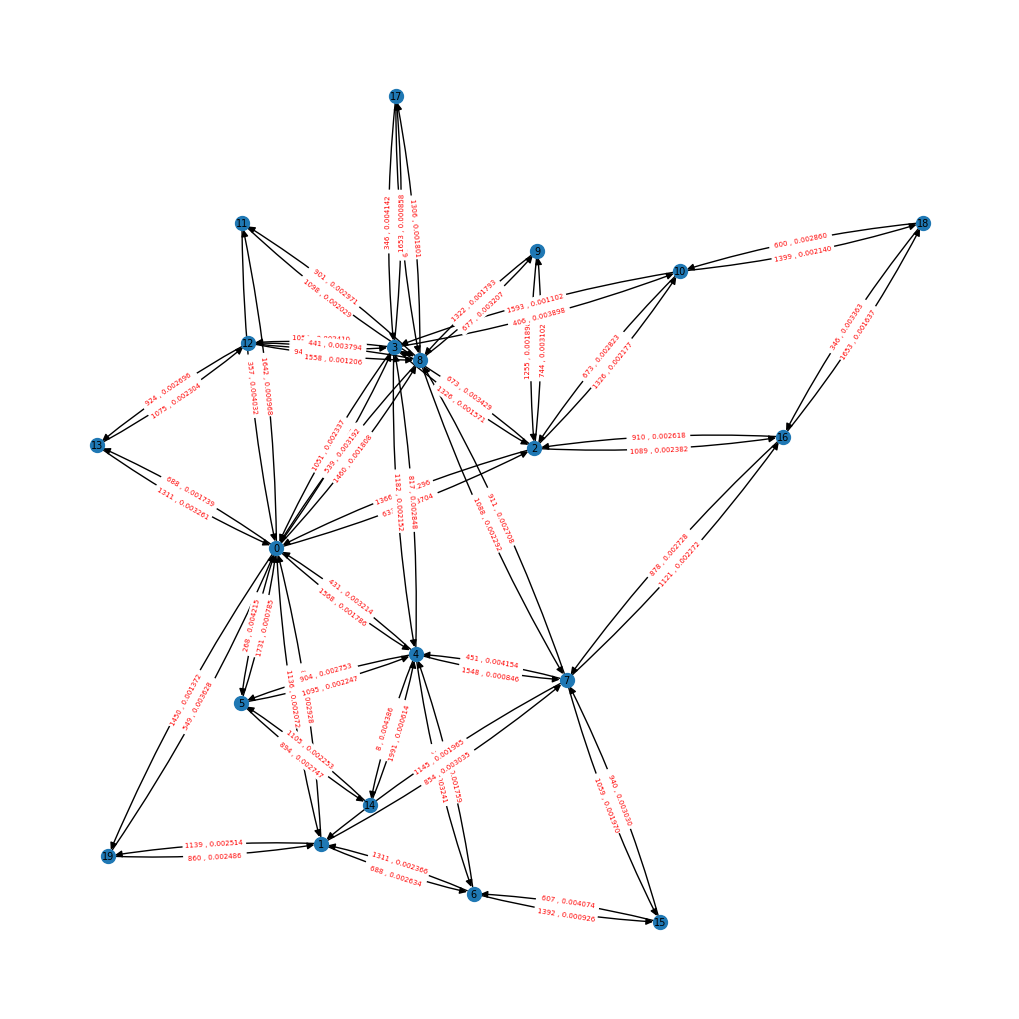

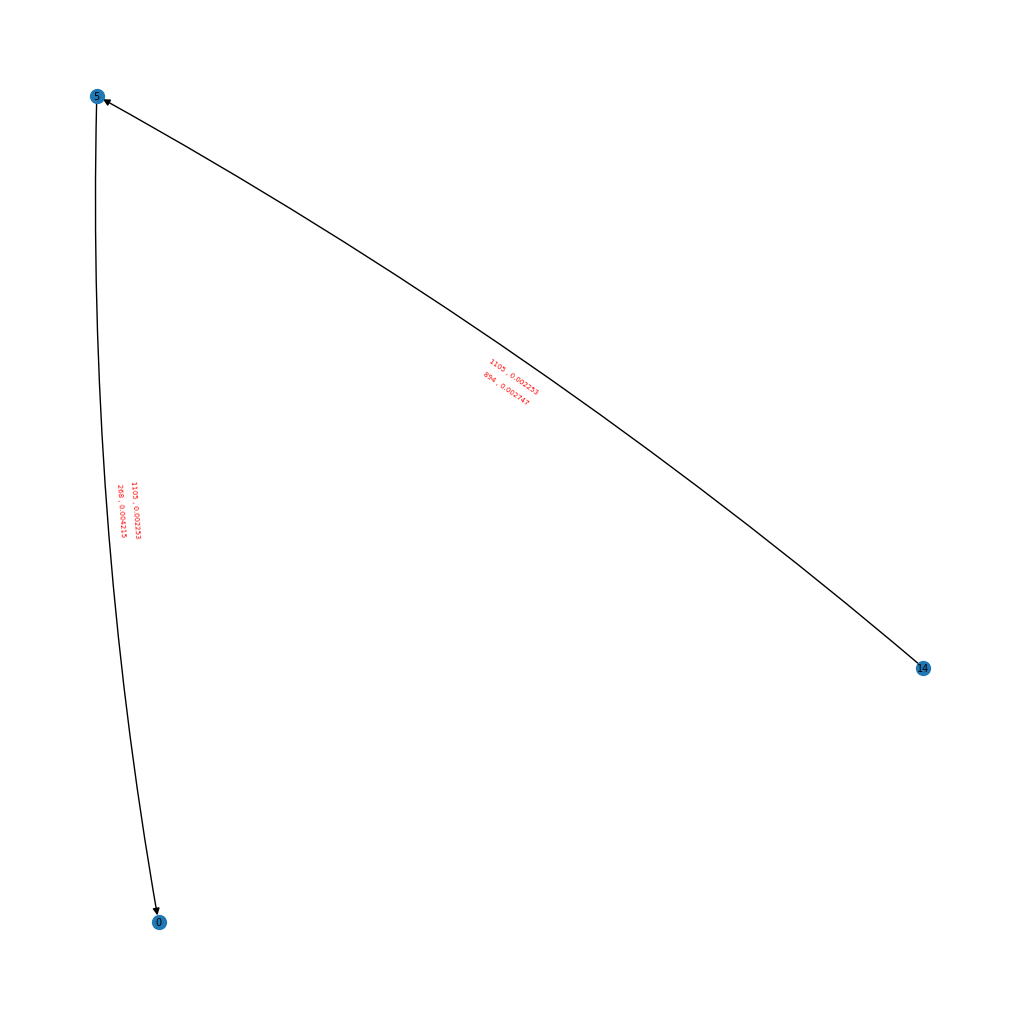

In [119]:
plotgraph(bidirectional_graph,sender[-1],recipient[-1],amount[-1],93)

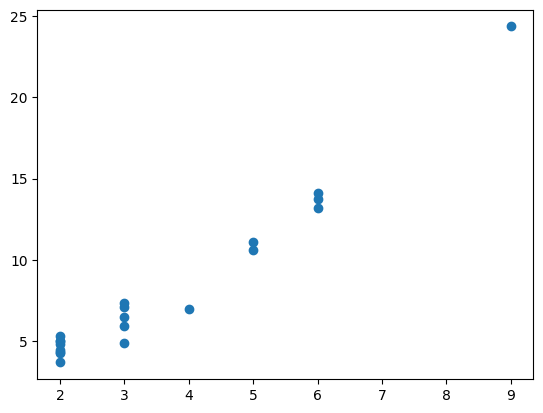

In [120]:
x_dgree=[]
y_balance=[]
for i in bidirectional_graph.nodes():
    y_balance.append(bidirectional_graph.nodes()[i]['balance'])
    x_dgree.append(bidirectional_graph.degree(i)/2)
plt.scatter(x_dgree,y_balance)

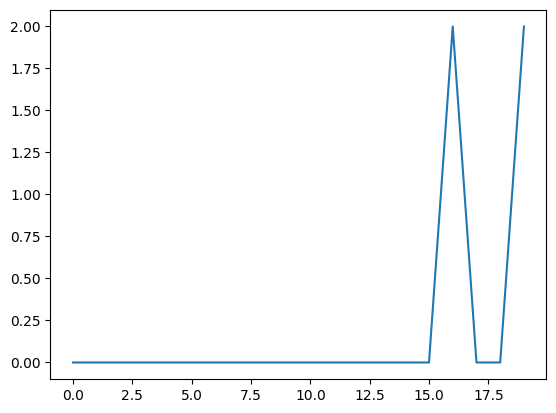

In [121]:
plt.plot(g)

6.185015776304817
56.66135671971599
7.3435187680327
5.4629148096929425
193.1068141581382
50.54637468324791
50.875389204138855
21.13940228504356
21.13940228504356
28.110152349511612
28.110152349511612
7.475872919892432
13.012536914146724
32.910405239933255
32.910405239933255
32.910405239933255
8.425395588837187
6.689120372101445
262.2673735225683
262.2673735225683
6.787144455588747
6.787144455588747
124.08772506590311
124.08772506590311
47.196861722925014
47.196861722925014
56.63350586791663
56.63350586791663
46.48855105276282
46.48855105276282
0.9115423411748534
3.110383016608461
3.110383016608461
6.158347495023598
6.158347495023598
34.40900704061822
34.40900704061822
8.311867305312775
15.849997927129627
6.3960422825893435
10.852140184902398
46.038312971565546
46.038312971565546
52.90808259712608
13.005011462178302
13.005011462178302
51.92304883842239
11.886022626722859
11.886022626722859
22.815000739337634
22.815000739337634
13.443184240061262
13.443184240061262
13.443184240061262
42.

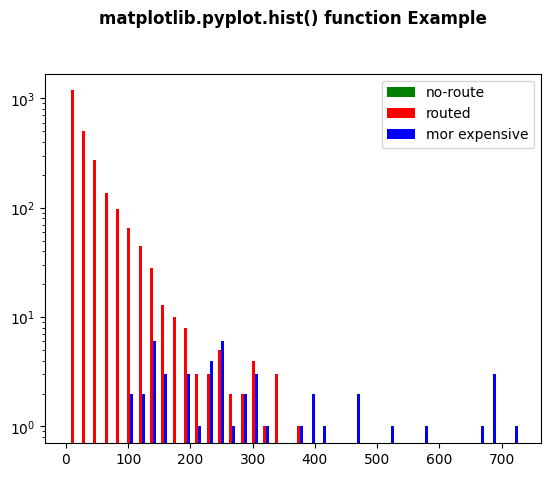

In [122]:
x=[]
y=[]
z=[]
for i in no_route:
  x.append(float(i))
for i in routed:
  print(i)
  y.append(float(i))
for i in more_exp:
  z.append(float(i))
label =['no-route','routed','mor expensive']
colors = ['green', 'red', 'blue']
 
plt.hist([x,y,z], 40,
         histtype ='bar',
         color = colors,
         label = label,
         log = True)
 
plt.legend(prop ={'size': 10})
 
plt.title('matplotlib.pyplot.hist() function Example\n\n',
          fontweight = "bold")
 
plt.show()

In [127]:
more_exp

[241.10876030449037,
 241.10876030449037,
 262.2673735225683,
 193.2277623926276,
 187.44897199898256,
 130.790154877983,
 130.790154877983,
 309.4323189627084,
 309.4323189627084,
 141.32533699796073,
 94.42174964149017,
 244.18088476015234,
 244.18088476015234,
 728.9404519610528,
 160.02831486453832,
 657.0303700023243,
 308.05823477598966,
 688.0867555807779,
 688.0867555807779,
 688.0867555807779,
 132.87006806678306,
 121.43801616774064,
 120.14240301075135,
 230.4191795111626,
 230.4191795111626,
 466.67356162308516,
 466.67356162308516,
 241.1410373526945,
 327.52705064456245,
 286.30961803047126,
 286.30961803047126,
 163.00247577868316,
 159.0416800353373,
 403.7572154473967,
 128.44176161033553,
 393.7129491533803,
 393.7129491533803,
 234.55841495820897,
 255.31863661603873,
 134.53905328354384,
 375.4661366060166,
 185.41518742687268,
 107.971588763658,
 511.9992196028428,
 228.4512050043793,
 578.0243531238531,
 204.80846770776284]

Text(0.5, 1.0, 'matplotlib.pyplot.hist() function Example\n\n')

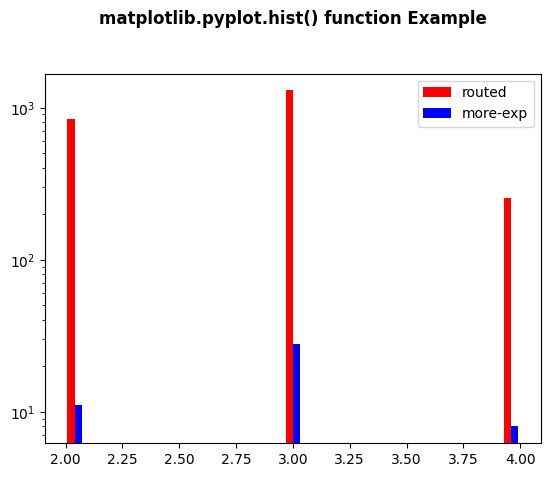

In [125]:
label =['routed','more-exp']
colors = ['red', 'blue']
 
plt.hist([path_r,path_ex], 25,
         color = colors,
         label = label,
         log= True)
 
plt.legend(prop ={'size': 10})
 
plt.title('matplotlib.pyplot.hist() function Example\n\n',
          fontweight = "bold")

In [124]:

pay_matrix=change_graph(bidirectional_graph,opt_path,amount)
pay_matrix

ValueError: I/O operation on closed file.

In [ ]:
 bidirectional_graph[7][1]

{'weight': 1795.628380929294, 'fee': 0.00015500108635118403}

In [ ]:
with open('log5_10.txt', 'w') as f:
    change_graph(bidirectional_graph,opt_path,amount)
    f.close()

In [ ]:
x=[(1,2),(3,4),(10,9)]
x[1:]

[(3, 4), (10, 9)]

In [ ]:
False_sim

[(0,
  90.22765230768849,
  [(17, 8), (8, 7), (7, 16)],
  [(17, 3), (3, 10), (10, 18), (18, 16)]),
 (0,
  12.57619668454002,
  [(15, 6), (6, 4), (4, 14)],
  [(15, 7), (7, 16), (3, 4), (4, 14)]),
 (2,
  39.24443844846075,
  [(9, 2), (2, 10), (10, 18)],
  [(9, 8), (8, 7), (7, 16), (16, 18)]),
 (2, 58.67811314098796, [(18, 16), (16, 2), (2, 9)], []),
 (3,
  14.633870652601804,
  [(13, 0), (0, 2), (2, 9)],
  [(13, 0), (0, 4), (10, 2), (2, 9)]),
 (4, 5.231661841592564, [(0, 5)], [(0, 5), (15, 7), (7, 1)])]